## Quantile Regression DQN (QR-DQN)
The objective of this notebook is to provide a clear, straightforward guide on implementing QR-DQN from scratch with PyTorch. Distributional RL is powerful and I'm a little surprised how few tutorials there are on it.

QR-DQN enhances the traditional Deep Q-Network (DQN) by estimating the distribution of Q-values across different quantiles using quantile regression. This method allows for a more detailed and nuanced understanding of the action-value function, allowing stochasticity to be modeled and incorportated into action selection.

Building upon the principles of DQN and Categorical DQN (C51), QR-DQN has the network learn a distribution of quantiles for the Q-values corresponding to each action-state pair. Unlike C51, which constrains the value function to a fixed range and models only a segment of the distribution, QR-DQN offers a more flexible approach. The key advantage here is its simplicity; the primary hyperparameter required is the distribution's resolution, determined by the number of quantiles.

A strong understanding of DQN and familiary with PyTorch and quantile regression is recommended to get the most out of this notebook.

### Imports

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## The QR-Q-Network
The primary difference between a standard DQN Q-network and a Quantile Regression (QR) Q-network lies in their outputs. Traditional DQN models produce a single Q-value for each action given a state, resulting in outputs of `shape=(batch_size, n_actions)`. In contrast, QR-Q-networks generate a distribution of Q-values for each action-state pair, with outputs shaped as `shape=(batch_size, n_actions, n_quantiles)`.

Let's see how the QR-DQN network differs from that of vanilla DQN:

In [2]:
### Vanilla DQN Q-Network ###
class QNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        n_actions   = action_space.n
        
        self.dense_input  = nn.Linear(obs_length,  hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, n_actions)
        
    def forward(self, x):
        x = F.relu(self.dense_input(x))
        x = F.relu(self.dense_hidden(x))
        x = self.dense_output(x)
        return x
    

### QR DQN Q-Network ###
class QRQNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64,  n_quantiles=49):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        self.n_actions   = action_space.n
        self.n_quantiles = n_quantiles
        
        self.dense_input  = nn.Linear(obs_length,  hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, action_space.n * n_quantiles)
        
    def forward(self, x):
        x = F.relu(self.dense_input(x))
        x = F.relu(self.dense_hidden(x))
        x = self.dense_output(x)
        return x.view(-1, self.n_actions, self.n_quantiles)

## Action Selection
Action selection is almost the same, only the last line uses an inplace `.mean(-1)`, which computes the expected value of the distribution, then selects the action which has the largest expected value from its distribution.

In [3]:
### Vanilla DQN action selection ###
def select_action(self, observation, epsilon):
        # Epsilon greedy action selection
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        # Else, select action with largest Q-value in given state
        observation_tensor = torch.tensor(observation, device=self.config['device']).unsqueeze(0)
        return self.online_network(observation_tensor).argmax().item()


### QR-DQN action selection ###
def select_action(self, observation, epsilon):
    # Epsilon greedy action selection
    if np.random.rand() < epsilon:
        return self.env.action_space.sample()
    # Else, select action with largest Q-value in given state
    observation_tensor = torch.tensor(observation, device=self.config['device']).unsqueeze(0)
    return self.online_network(observation_tensor).mean(-1).argmax().item()

## Loss Calculation
The loss calculation is the most complex part of QR-DQN, but it's still fairly straightforward, particularly if you're familiar with quantile regression.

### Vanilla DQN Loss
First, let's look at the loss calculation for vanilla DQN, then compare it to QR-DQN to see what's different.

In [4]:
### Vanilla DQN loss calculation ###
def calculate_loss(states, actions, rewards, next_states, dones):                          # Takes batched tensors from experience tuples
    current_state_q_values = online_network(states)                                        # Compute predicted Q-values for current state
    current_action_q_values = torch.gather(current_state_q_values, dim=1, index=actions)   # Get Q-value for each action taken
    with torch.no_grad():
        next_state_q_values = target_network(next_states)                                  # Use target network for next state Q-values
        next_state_max_q_values = torch.max(next_state_q_values, dim=1, keepdims=True)[0]  # Assume we choose the best action in next state
        target_q_values = rewards + gamma * (1. - dones) * next_state_max_q_values         # Compute targets with Bellman equation
    loss = torch.nn.functional.mse_loss(current_action_q_values, target_q_values)          # Loss is MSE between target and predictions
    return loss

### QR-DQN Loss
The loss calculation in QR-DQN is significantly different from that in vanilla DQN. It employs an asymmetrically weighted Huber loss to accommodate the quantile regression framework.

#### Huber Loss
The Huber loss function is a piecewise function that combines the best of both worlds from mean squared error (MSE) and mean absolute error (MAE). It applies a quadratic loss to errors within a certain range (`-kappa` to `+kappa`) and a linear loss to those outside this range. This approach mitigates the sensitivity to outliers in error distribution, making it well-suited for quantile regression in QR-DQN.

Below is a Huber loss function definition and its comparison with MAE and MSE losses graphically:

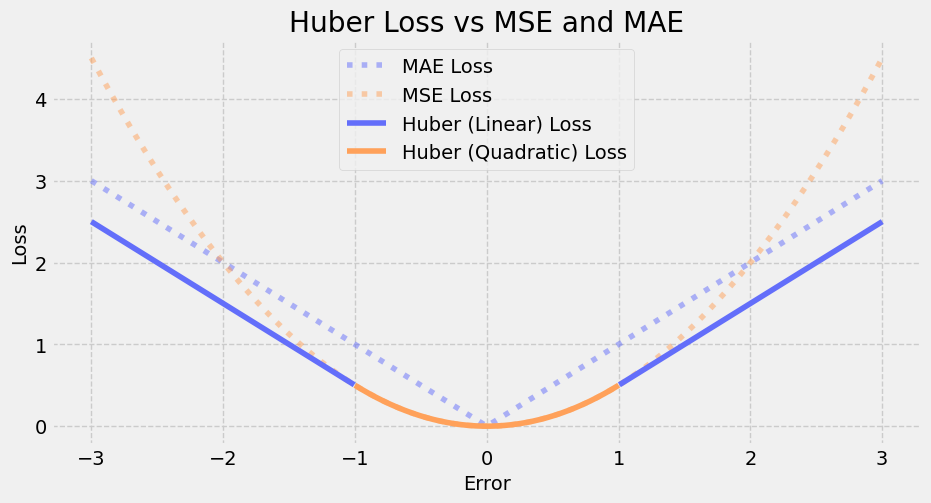

In [5]:
# Define the Huber loss function
def huber_loss(td_error, kappa):
    # Note multiplying squared losses by 0.5 simplifies backprop calcs, we do this for the linear part so all loss is scaled the same
    return torch.where(td_error.abs() <= kappa,                 # Values between -kappa and +kappa
                       0.5 * td_error.pow(2),                   # have quadratic loss
                       kappa * (td_error.abs() - 0.5 * kappa))  # otherwise have linear loss

# Generate loss data
x = np.linspace(-3, 3, 1000)
x_torch = torch.tensor(x, dtype=torch.float32)

# Kappa value (threshold between quadratic and linear)
kappa = 1.

# Calculate Huber loss
y = huber_loss(x_torch, kappa)

# Break the plot into three distinct parts based on the x values relative to kappa for plotting
x_linear_left = x[x < -kappa]
y_linear_left = y.numpy()[x < -kappa]
x_linear_right = x[x > kappa]
y_linear_right = y.numpy()[x > kappa]
x_quadratic = x[(x >= -kappa) & (x <= kappa)]
y_quadratic = y.numpy()[(x >= -kappa) & (x <= kappa)]

# Calculate MAE and MSE for comparison
y_mae = np.abs(x)
y_mse = 0.5 * x**2

# Create the plot
plt.figure(figsize=(10, 5))

# Plot MAE and MSE
plt.plot(x, y_mae, color='#636EFA', alpha=0.5, ls=':', label='MAE Loss')
plt.plot(x, y_mse, color='#FFA15A', alpha=0.5, ls=':', label='MSE Loss')


plt.plot(x_linear_left, y_linear_left, color='#636EFA', label='Huber (Linear) Loss')
plt.plot(x_linear_right, y_linear_right, color='#636EFA')
plt.plot(x_quadratic, y_quadratic, color='#FFA15A', label='Huber (Quadratic) Loss')

# Format plot
plt.title('Huber Loss vs MSE and MAE')
plt.xlabel('Error')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

#### Quantile Huber Loss
To accurately learn the distribution of Q-values, QR-DQN employs a modified version of the Huber loss, known as the Quantile Huber Loss. This adaptation allows the model to learn distinct quantiles within the value distribution by assigning unique objectives to each quantile, effectively tailoring the loss to penalise underestimations and overestimations differently based on the target quantile.

- **0.25 Quantile**: For the first quartile, the goal is for the model to predict a value that is not exceeded 25% of the time and exceeded 75% of the time. To achieve this, the model incurs a larger penalty for underestimating than overestimating. The adjustment encourages the model to lean towards underprediction for this quantile.

- **0.5 Quantile (Median)**: The median quantile treats overestimations and underestimations equally, only using the standard Huber loss in its computation.

- **0.75 Quantile**: This quantile mirrors the 0.25 quantile's approach but inverts the penalty logic. The objective is to predict a threshold that the value exceeds 75% of the time but falls below 25% of the time. It imposes a greater penalty for overestimating, pushing the model to prefer overprediction.

Let's visualise what loss looks like for different quantiles:

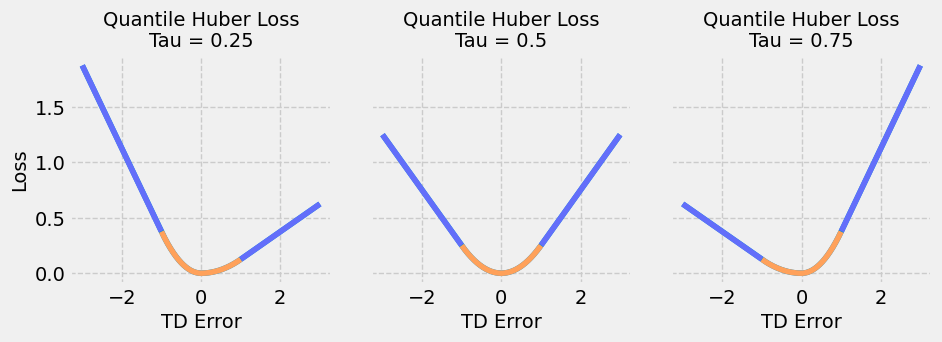

In [6]:
def plot_quantile_huber_loss(kappa=1.0, quantiles=[0.25, 0.5, 0.75]):
    # Generate loss data
    errors = np.linspace(-3, 3, 1000)
    errors_torch = torch.tensor(errors, dtype=torch.float32)

    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
    plt.subplots_adjust(wspace=0.3)

    for i, tau in enumerate(quantiles):
        # Calculate TD error (simulating with the errors variable directly)
        td_error = errors_torch
        
        # Huber loss calculation
        huber_loss_val = torch.where(td_error.abs() <= kappa,
                                     0.5 * td_error.pow(2),
                                     kappa * (td_error.abs() - 0.5 * kappa))

        # Quantile loss calculation
        quantile_loss_val = torch.abs(torch.tensor(tau) - (td_error < 0).float()) * huber_loss_val

        # Plot
        axes[i].plot(errors, quantile_loss_val.numpy(), label=f'Tau = {tau}')
        axes[i].set_title(f'Quantile Huber Loss\nTau = {tau}', fontsize=14)
        axes[i].set_xlabel('TD Error')
        axes[i].grid(True, which='both', linestyle='--')
        
        # Highlighting sections for clarity
        axes[i].plot(errors[errors < -kappa], quantile_loss_val.numpy()[errors < -kappa], color='#636EFA')
        axes[i].plot(errors[(errors >= -kappa) & (errors <= kappa)], quantile_loss_val.numpy()[(errors >= -kappa) & (errors <= kappa)], color='#FFA15A')
        axes[i].plot(errors[errors > kappa], quantile_loss_val.numpy()[errors > kappa], color='#636EFA')
    
    axes[0].set_ylabel('Loss')
    plt.tight_layout(pad=2)
    plt.show()

plot_quantile_huber_loss()

### Quantile Huber Loss Function

Instead of directly presenting optimised and convoluted code for the Quantile Huber Loss function, we'll go through a worked example to clarify loss calculation in QR-DQN.

#### Worked loss calculation:

In [7]:
# Predictions from the online network for the current state, separated by quantiles.
preds = torch.tensor([
    [[1, 2, 4], [ 2, 3, 4], [1, 3, 5], [1, 2, 3]],
    [[2, 3, 4], [-1, 0, 1], [1, 3, 5], [1, 2, 5]]
], dtype=torch.float32)

# Target Q-values for each quantile from the target network for next states.
targets = torch.tensor([
    [[2, 3, 4], [ 3, 4, 6], [1, 2, 5], [1, 3, 4]],
    [[2, 4, 5], [-1, 0, 2], [1, 2, 3], [0, 1, 4]]
], dtype=torch.float32)

# Actions selected by the policy for each sample in the batch.
actions = torch.tensor([2, 3])

# Preparing actions for gathering by reshaping: [batch_size] -> [batch_size, 1, 1].
actions_reshaped = actions.view(-1, 1, 1)

# Expand actions to match the preds tensor's last dimension (n_quantiles).
actions_expanded = actions_reshaped.expand(-1, -1, preds.shape[2])
# [[[2, 2, 2]],
#  [[3, 3, 3]]]

# Gather predicted Q-values for the selected actions across each quantile.
preds_gathered = torch.gather(preds, dim=1, index=actions_expanded)
# [[[1, 3, 5]],  action 2 Q-values
#  [[1, 2, 5]]]  action 3 Q-values

# Next, target calculation.
# Calculate mean expected Q-values for each action by averaging across all quantiles.
expected_q_values = torch.mean(targets, dim=2)
# [[3.0000, 4.3333, 2.6667, 2.6667],
#  [3.6667, 0.3333, 2.0000, 1.6667]])

# Identify actions with the maximum expected Q-value for the next states.
next_state_best_actions = torch.argmax(expected_q_values, dim=1, keepdims=True).unsqueeze(-1)
# [[[1]],   action 1 has the highest mean Q-value
#  [[0]]])  action 0 has the highest mean Q-value

# Gather the Q-value distributions for these best actions from the target predictions.
next_state_max_q_values = torch.gather(targets, dim=1, index= next_state_best_actions.expand(-1, -1, preds.shape[2]))
# [[[3, 4, 6]],  action 1 Q-values
#  [[2, 4, 5]]]) action 0 Q-values

# Reward received and done flags for each sample in the batch.
rewards = torch.tensor([1, 2], dtype=torch.float32).view(-1, 1, 1)
dones = torch.tensor([0, 1], dtype=torch.float32).view(-1, 1, 1)  # 0 for not done, 1 for done

# Discount factor for future rewards.
gamma = 0.99

# Calculate the target Q-values. For terminal states, use only the reward.
target_q_values = rewards + (gamma * next_state_max_q_values * (1 - dones))
# [[[3.9700, 4.9600, 6.9400]],   not done, so Q-target is reward + gamma * next_state_q
#  [[2.0000, 2.0000, 2.0000]]])  done here so just reward

# Compute TD error between the predicted and target Q-values.
td_error = target_q_values - preds_gathered
# [[[ 2.9700,  1.9600,  1.9400]],
#  [[ 1.0000,  0.0000, -3.0000]]])

# Calculate the Quantile Huber loss
kappa = 1.0                                                   # Threshold for Huber loss
n_quantiles = preds.size(2)                                   # Get number of quantiles from preds
taus = torch.linspace(0.0, 1.0, steps=n_quantiles + 2)[1:-1]  # Tau values, excluding 0 and 1
taus = taus.unsqueeze(0).unsqueeze(0)                         # Reshape for broadcasting: [1, 1, n_quantiles]

# Huber loss component
condition = td_error.abs() <= kappa                               # Is prediciton between -kappa and +kappa

# Quadratic for small errors and linear for large, to reduce sensitivity to outliers
huber_loss = torch.where(condition,                               # For any errors of magnitude below kappa (small errors)
                         0.5 * td_error.pow(2),                   # Use squared error
                         kappa * (td_error.abs() - 0.5 * kappa))  # Otherwise use absolute error

# Calculating Quantile Loss:
# The quantile loss calculation takes into account whether the TD error is negative (underestimation) or positive (overestimation).
# For a low tau (e.g., 0.25 quantile), an overestimation (td_error > 0) implies a smaller loss since (tau - 0) * huber_loss (0.25) is relatively small.
# Conversely, for an underestimation (td_error < 0), the loss is larger as it's calculated as abs(tau - 1) * huber_loss (0.75) reflecting a larger penalty.
# At the median (0.5 quantile), overestimations and underestimations are treated equally, as abs(tau - (td_error > 0)) will always equal 0.5.
# For high tau values (e.g., 0.75 quantile), the situation reverses: underestimations incur less penalty compared to overestimations.

# TD errors:
# [[[ 2.9700,  1.9600,  1.9400]],
#  [[ 1.0000,  0.0000, -3.0000]]])

# Quantile losses:
# [[[0.6175, 0.7300, 1.0800]],
#  [[0.1250, 0.0000, 0.6250]]]

# Notice that the 0.25 quantile TD loss is large (3), but the quantile loss is lower than that of the median loss which only
# had a TD loss of 1.96. This is because the 0.25 quantile is less punished for overestimating the Q-value.
quantile_loss = torch.abs(taus - (td_error < 0).float()) * huber_loss

# The overall loss is computed by averaging the quantile losses across all samples and quantiles.
loss = quantile_loss.mean()

print(f"Quantile Huber Loss: {loss.item():.5f}")

Quantile Huber Loss: 0.52958


## Full Vanilla DQN Implementation
For any curious readers, this is my simple vanilla DQN implementation for comparison:

In [8]:
import numpy as np
import torch
from torch import nn
from collections import deque
import random

dqn_config = {
    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Network settings
    'hidden_size'           :      8,  # Number of neurons in Q-network hidden layer
    
    # Buffer settings
    'batch_size'            :    128,  # Number of experience tuples sampled per learning update
    'buffer_size'           : 100000,  # Maximum length of replay buffer
     
    # Target network settings 
    'target_update_interval':   1000,  # How often to perform target network weight synchronisations
    'tau'                   :    1.0,  # When copying online network weights to target network, what weight is given to online network weights
     
    # Exploration settings 
    'exploration_start_eps' :     1.,  # Initial epsilon to use
    'exploration_final_eps' :   0.05,  # Lowest possible epsilon value
    'exploration_fraction'  :    0.4,  # Fraction of entire training period over which the exploration rate is reduced
     
    # Learning settings 
    'learning_starts'       :    200,  # Step to begin learning at
    'train_frequency'       :      3,  # Performs a learning update every `train_frequency` steps
    'lr'                    :   1e-4,  # Learning rate
    'gamma'                 :   0.99,  # Discount factor
  
    # Callback settings 
    'reward_target'         :    195,  # If set to a number, training will stop when mean reward for recent episodes exceeds this
    'verbose'               :   True,  # Prints steps and rewards in output
}

class ReplayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def push(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones
        
    def __len__(self):
        return len(self.buffer)
    
class QNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        n_actions   = action_space.n
        self.activation   = nn.ReLU()
        self.dense_input  = nn.Linear(obs_length,  hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, n_actions)
        
    def forward(self, x):
        x = self.activation(self.dense_input(x))
        x = self.activation(self.dense_hidden(x))
        x = self.dense_output(x)
        return x
    
class DQN:
    def __init__(self, config):
        self.config = config
        
    def set_env(self, env):
        self.env = env
        self.initialize_agent()
            
    def initialize_agent(self):
        # Get observation space, action space and device
        action_space = self.env.action_space
        observation_space = self.env.observation_space
        device = self.config['device']
        
        # Set networks and synchronise weights
        self.online_network = QNetwork(action_space, observation_space, self.config['hidden_size']).to(device)
        self.target_network = QNetwork(action_space, observation_space, self.config['hidden_size']).to(device)
        self.update_target_network(1.)
        
        self.optimizer = torch.optim.AdamW(self.online_network.parameters(), lr=self.config['lr'])
        
        # Set replay buffer
        self.buffer = ReplayBuffer(self.config['buffer_size'])
        
    def update_target_network(self, tau):
        "Updates the parameters of the target network, tau controls how fully the weights are copied."
        with torch.no_grad():
            for target_param, online_param in zip(self.target_network.parameters(), self.online_network.parameters()):
                target_param.data.copy_(tau * online_param.data + (1. - tau) * target_param.data)
                
    def select_action(self, observation, epsilon):
        # Epsilon greedy action selection
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        # Else, select action with largest Q-value in given state
        observation_tensor = torch.tensor(observation, device=self.config['device']).unsqueeze(0)
        return self.online_network(observation_tensor).argmax().item()
    
    def calculate_exploration_rate(self, step, total_steps):
        epsilon_start = self.config['exploration_start_eps']
        epsilon_end = self.config['exploration_final_eps']
        epsilon_decay_steps = total_steps * self.config['exploration_fraction']
        return max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay_steps))
        
    def train(self, total_steps):
        "Trains agent for a given number of steps according to given configuration."
        # Tracking information
        episode_count = 0
        episodic_reward = 0.
        episode_rewards = [np.NaN]
        
        # Reset episode
        observation, _ = self.env.reset()
        
        # Main training loop
        for step in range(1, total_steps + 1):
            # Set exploration 
            epsilon = self.calculate_exploration_rate(step, total_steps)
            
            # Get action and execute in envrionment
            action = self.select_action(observation, epsilon)
            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Push experience to buffer
            self.buffer.push((observation, action, reward, next_observation, done))

            if done:
                # Tracking
                episode_count += 1
                episode_rewards.append(episodic_reward)
                episodic_reward = 0.
                
                # Reset environment
                observation, _ = self.env.reset()
            else:
                episodic_reward += reward
                observation = next_observation
            
            # Perform learning step
            if step % self.config['train_frequency'] == 0 and step > self.config['learning_starts']:
                self.learn()
            
            # Update target network
            if step % self.config['target_update_interval'] == 0:
                self.update_target_network(self.config['tau'])
                
            # If mean of last 20 rewards exceed target, end training
            if np.mean(episode_rewards[-20:]) >= self.config['reward_target']:
                return
            
            # Print training info if verbose
            if self.config['verbose'] and step % 100 == 0:
                print(f"\rStep: {step}/{total_steps} \t Avg reward: {np.mean(episode_rewards[-20:]):.3f}\t Episode: {episode_count}    ", end='')
                if step % 10000 == 0:
                    print()
    
    def learn(self):
        # Load batch and create tensors
        states, actions, rewards, next_states, dones = self.buffer.sample(self.config['batch_size'])
        states      = torch.tensor(states,      dtype=torch.float32, device=self.config['device'])
        actions     = torch.tensor(actions,     dtype=torch.long,    device=self.config['device']).unsqueeze(1)
        rewards     = torch.tensor(rewards,     dtype=torch.float32, device=self.config['device']).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.config['device'])
        dones       = torch.tensor(dones,       dtype=torch.float32, device=self.config['device']).unsqueeze(1)
        
        # Predicted Q-values for current state
        current_state_q_values = self.online_network(states)
        
        # Gather Q-values of actions actually taken
        current_action_q_values = torch.gather(current_state_q_values, dim=1, index=actions)
        
        with torch.no_grad():
            # Compute target
            next_state_q_values = self.target_network(next_states)
            
            # Assume agent chooses the largest of these Q-values
            next_state_max_q_values = torch.max(next_state_q_values, dim=1, keepdims=True)[0]
            
            # Bellman equation to compute target Q-values
            target_q_values = rewards + self.config['gamma'] * (1. - dones) * next_state_max_q_values
        
        # Calculate loss
        loss = torch.nn.functional.mse_loss(current_action_q_values, target_q_values)
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## Full QR-DQN Implementation
Below is a succinct QR-DQN agent that incorporates all the modifications and concepts previously outlined. This includes:

- **Network Architecture**: Adjusted to output Q-value distributions across multiple quantiles for each action.
- **Action Selection**: Modified to select actions based on the expected value of the distribution.
- **Loss Calculation**: Employing the Quantile Huber Loss to accurately learn the Q-value distributions.

In [9]:
import numpy as np
import torch
from torch import nn
from collections import deque
import random

qrdqn_config = {
    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Quantile regression
    'n_quantiles'           :      9,  # For Cartpole, just use the 10th percentiles, [0.1, 0.2, ... 0.8, 0.9]
    
    # Network settings
    'hidden_size'           :      8,  # Number of neurons in Q-network hidden layer
    
    # Buffer settings
    'batch_size'            :     32,  # Number of experience tuples sampled per learning update
    'buffer_size'           : 100000,  # Maximum length of replay buffer
     
    # Target network settings 
    'target_update_interval':   1000,  # How often to perform target network weight synchronisations
    'tau'                   :    1.0,  # When copying online network weights to target network, what weight is given to online network weights
     
    # Exploration settings 
    'exploration_start_eps' :     1.,  # Initial epsilon to use
    'exploration_final_eps' :   0.05,  # Lowest possible epsilon value
    'exploration_fraction'  :    0.4,  # Fraction of entire training period over which the exploration rate is reduced
     
    # Learning settings 
    'learning_starts'       :    200,  # Step to begin learning at
    'train_frequency'       :      3,  # Performs a learning update every `train_frequency` steps
    'lr'                    :   1e-3,  # Learning rate
    'gamma'                 :   0.99,  # Discount factor
  
    # Callback settings 
    'reward_target'         :    195,  # If set to a number, training will stop when mean reward for recent episodes exceeds this
    'verbose'               :   True,  # Prints steps and rewards in output
}

class ReplayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def push(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones
        
    def __len__(self):
        return len(self.buffer)
    
class QRQNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64,  n_quantiles=51):
        super().__init__()
        obs_length  = np.prod(observation_space.shape)
        self.n_actions   = action_space.n
        self.n_quantiles = n_quantiles
        self.activation   = nn.ReLU()
        self.dense_input  = nn.Linear(obs_length,  hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, action_space.n * n_quantiles)
        
    def forward(self, x):
        x = self.activation(self.dense_input(x))
        x = self.activation(self.dense_hidden(x))
        x = self.dense_output(x)
        return x.view(-1, self.n_actions, self.n_quantiles)
    
class QRDQN:
    def __init__(self, config):
        self.config = config
        
    def set_env(self, env):
        self.env = env
        self.initialize_agent()
            
    def initialize_agent(self):
        # Get observation space, action space and device
        action_space = self.env.action_space
        observation_space = self.env.observation_space
        device = self.config['device']
        
        # Set networks and synchronise weights
        self.online_network = QRQNetwork(action_space, observation_space, self.config['hidden_size'], self.config['n_quantiles']).to(device)
        self.target_network = QRQNetwork(action_space, observation_space, self.config['hidden_size'], self.config['n_quantiles']).to(device)
        self.update_target_network(1.)
        
        self.optimizer = torch.optim.AdamW(self.online_network.parameters(), lr=self.config['lr'])
        
        # Set replay buffer
        self.buffer = ReplayBuffer(self.config['buffer_size'])
        
    def update_target_network(self, tau):
        "Updates the parameters of the target network, tau controls how fully the weights are copied."
        with torch.no_grad():
            for target_param, online_param in zip(self.target_network.parameters(), self.online_network.parameters()):
                target_param.data.copy_(tau * online_param.data + (1. - tau) * target_param.data)
                
    def select_action(self, observation, epsilon):
        # Epsilon greedy action selection
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        # Else, select action with largest Q-value in given state
        observation_tensor = torch.tensor(observation, device=self.config['device']).unsqueeze(0)
        return self.online_network(observation_tensor).mean(-1).argmax().item()
    
    def calculate_exploration_rate(self, step, total_steps):
        epsilon_start = self.config['exploration_start_eps']
        epsilon_end = self.config['exploration_final_eps']
        epsilon_decay_steps = total_steps * self.config['exploration_fraction']
        return max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay_steps))
        
    def train(self, total_steps):
        "Trains agent for a given number of steps according to given configuration."
        # Tracking information
        episode_count = 0
        episodic_reward = 0.
        episode_rewards = [np.NaN]
        
        # Reset episode
        observation, _ = self.env.reset()
        
        # Main training loop
        for step in range(1, total_steps + 1):
            # Set exploration 
            epsilon = self.calculate_exploration_rate(step, total_steps)
            
            # Get action and execute in envrionment
            action = self.select_action(observation, epsilon)
            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Push experience to buffer
            self.buffer.push((observation, action, reward, next_observation, done))

            if done:
                # Tracking
                episode_count += 1
                episode_rewards.append(episodic_reward)
                episodic_reward = 0.
                
                # Reset environment
                observation, _ = self.env.reset()
            else:
                episodic_reward += reward
                observation = next_observation
            
            # Perform learning step
            if step % self.config['train_frequency'] == 0 and step > self.config['learning_starts']:
                self.learn()
            
            # Update target network
            if step % self.config['target_update_interval'] == 0:
                self.update_target_network(self.config['tau'])
                
            # If mean of last 20 rewards exceed target, end training
            if np.mean(episode_rewards[-20:]) >= self.config['reward_target']:
                return
            
            # Print training info if verbose
            if self.config['verbose'] and step % 100 == 0:
                print(f"\rStep: {step}/{total_steps} \t Avg reward: {np.mean(episode_rewards[-20:]):.3f}\t Episode: {episode_count}    ", end='')
                if step % 10000 == 0:
                    print()
    
    def learn(self, kappa=1.0):
        # Load batch and create tensors
        states, actions, rewards, next_states, dones = self.buffer.sample(self.config['batch_size'])
        states      = torch.tensor(states, dtype=torch.float32, device=self.config['device'])
        actions     = torch.tensor(actions, dtype=torch.long, device=self.config['device']).view(-1, 1, 1)
        rewards     = torch.tensor(rewards, dtype=torch.float32, device=self.config['device']).view(-1, 1, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.config['device'])
        dones       = torch.tensor(dones, dtype=torch.float32, device=self.config['device']).view(-1, 1, 1)
        
        # Get number of quantiles from config
        n_quantiles = self.config['n_quantiles']
        
        # Predicted Q-value quantiles for current state
        current_state_q_values = self.online_network(states)
        
        # Gather Q-value quantiles of actions actually taken
        current_action_q_values = torch.gather(current_state_q_values, dim=1, index=actions.expand(-1, -1, n_quantiles))
        
        # Compute targets
        with torch.no_grad():
            # Get best actions in next state then gather Q-values with these actions
            next_state_q_values     = self.target_network(next_states)
            next_state_best_actions = torch.argmax(next_state_q_values.mean(dim=2), dim=1, keepdims=True).unsqueeze(-1)
            next_state_max_q_values = torch.gather(next_state_q_values, dim=1, index=next_state_best_actions.expand(-1, -1, n_quantiles))
            
            # Bellman equation to compute target Q-values for not done states
            target_q_values = rewards + self.config['gamma'] * next_state_max_q_values * (1 - dones)
        
        # Calculate TD error and Quantile Huber loss
        td_error = target_q_values - current_action_q_values
        huber_loss = torch.where(td_error.abs() <= kappa, 
                                 0.5 * td_error.pow(2), 
                                 kappa * (td_error.abs() - 0.5 * kappa))
        taus = torch.linspace(0.0, 1.0, steps=n_quantiles + 2, device=self.config['device'])[1:-1].unsqueeze(0).unsqueeze(0)
        quantile_loss = torch.abs(taus - (td_error < 0).float()) * huber_loss
        loss = quantile_loss.mean()
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## Train QR-DQN Agent
We train our QR-DQN agent on Gym's Cartpole environment.

In [10]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
agent = QRDQN(qrdqn_config)
agent.set_env(env)

agent.train(400000)

Step: 10000/400000 	 Avg reward: 24.750	 Episode: 434    

Step: 20000/400000 	 Avg reward: 29.250	 Episode: 806    

Step: 30000/400000 	 Avg reward: 31.050	 Episode: 1112    

Step: 40000/400000 	 Avg reward: 36.400	 Episode: 1375    

Step: 50000/400000 	 Avg reward: 46.250	 Episode: 1578    

Step: 60000/400000 	 Avg reward: 65.600	 Episode: 1745    

Step: 70000/400000 	 Avg reward: 89.900	 Episode: 1859     

Step: 80000/400000 	 Avg reward: 98.250	 Episode: 1975     

Step: 90000/400000 	 Avg reward: 133.050	 Episode: 2061    

Step: 100000/400000 	 Avg reward: 164.350	 Episode: 2128    

Step: 108800/400000 	 Avg reward: 190.600	 Episode: 2175    

## Visualising Q-value Distributions
Let's pass some sample states through our model and take a look at the Q-value quantile distributions:

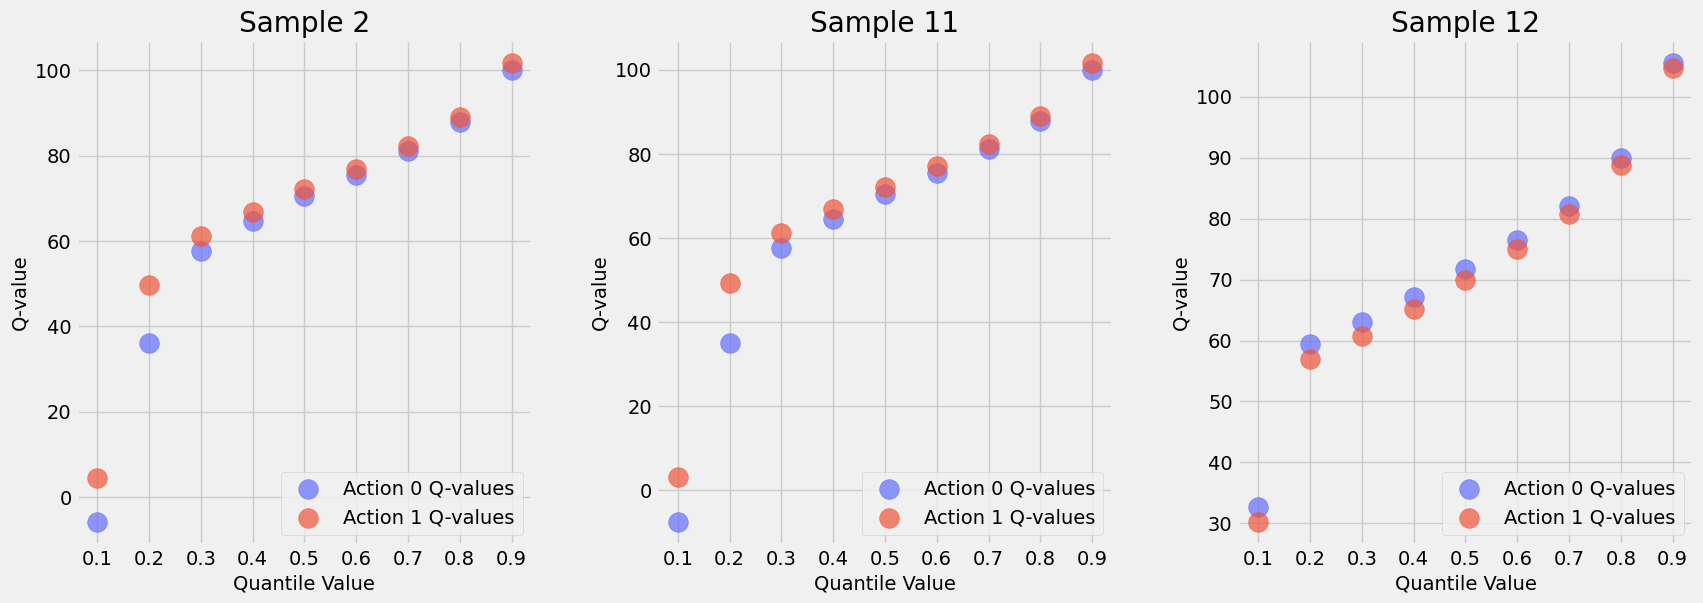

In [21]:
def plot_q_value_distributions(preds, sample_indices=[0]):
    n_samples = len(sample_indices)
    fig, axs = plt.subplots(1, n_samples, figsize=(6*n_samples, 7), squeeze=False)
    
    # Calculate quantile values
    n_quantiles = preds.shape[2]
    quantiles = np.linspace(0, 1, n_quantiles + 2)[1:-1]
    
    for idx, sample_index in enumerate(sample_indices):
        sample_preds = preds[sample_index].detach()
        
        action_0_q_values = sample_preds[0].cpu().numpy()
        action_1_q_values = sample_preds[1].cpu().numpy()
        
        axs[0, idx].scatter(quantiles, action_0_q_values, color='#636EFA', s=200, alpha=0.7, label='Action 0 Q-values')
        axs[0, idx].scatter(quantiles, action_1_q_values, color='#EF553B', s=200, alpha=0.7, label='Action 1 Q-values')
        
        axs[0, idx].set_title(f'Sample {sample_index}')
        axs[0, idx].set_xlabel('Quantile Value')
        axs[0, idx].set_ylabel('Q-value')
        axs[0, idx].set_xticks(quantiles)
        axs[0, idx].legend(loc='lower right')
        axs[0, idx].grid(True)
    
    plt.tight_layout(pad=3)
    plt.show()

# # Get states and predictions
states, actions, rewards, next_states, dones = agent.buffer.sample(agent.config['batch_size'])
states = torch.tensor(states, dtype=torch.float32, device=agent.config['device'])
preds = agent.online_network(states)    
    
# Display Q-value distributions
plot_q_value_distributions(preds, [2, 11, 12])